In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy
from scipy.stats import spearmanr
from scipy.stats import kstest, norm
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [2]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
   
# Suppress SettingWithCopyWarning


In [3]:
#check versions of packages
import sys
print(sys.version)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('seaborn:', sns.__version__)
print('re version:', re.__version__)
print('pytz version:', pytz.__version__)
print('sklearn version:', sklearn.__version__)
print('scipy version:', scipy.__version__)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.2.1
numpy version: 1.26.4
seaborn: 0.12.2
re version: 2.2.1
pytz version: 2023.3.post1
sklearn version: 1.2.2
scipy version: 1.11.4


In [4]:
data = pd.read_csv('CPS.csv')

In [5]:
# Select and rename relevant columns for analysis out of the 356 original columns 
selected_columns = {
    # Household Information
    'hrhhid2': 'household_id',
    'HUFINAL': 'interview_outcome',
    'hrnumhou': 'household_members',  # Number of members in a household
    'hefaminc' : 'family_income',

    # Education and Certification Details
    'peschlvl': 'highest_level_of_school',  # Highest level of school 
    'peeduca': 'education_level',  # Highest level of education completed
    'peedegr': 'highest_degree_earned',  # Highest degree earned
    'petrain': 'received_job_training',  # Received job training past high school
    'pecert1': 'professional_certification1',  # Professional certification 1
    'pecert2': 'cert_issued_by_state_or_gov',  # Is certificate issued by the state or the federal government?
    'pecert3': 'is_cert_required',  # Is certification needed for the job?

    # Employment and Income Details
    'pemlr': 'employment_status',  # Employment status
    'prunedor': 'duration_of_unemployment',  # Duration of unemployment
    'hefaminc': 'family_income',  # Family income
    'primind1': 'primary_industry_code_job1',  # Primary industry code for job 1
    'peio1icd': 'industry_code_job1',  # Industry code for job 1
    'ptio1ocd': 'occupation_code_job1',  # Occupation code for job 1
    'primind2': 'primary_industry_code_job2',  # Primary industry code for job 2
    'peio2icd': 'industry_code_job2',  # Industry code for job 2
    'ptio2ocd': 'occupation_code_job2',  # Occupation code for job 2
    'puwk': 'did_work_last_week',  # Did the individual work last week
    
    # Earnings
    'pternh1c': 'earnings_first_job',  # Earnings from the first job
    'pthr': 'total_hours_worked',  # Total hours worked
    'pternwa': 'weekly_earnings',  # Weekly earnings

    # Demographic Variables
    'ptdtrace': 'race',  # Race
    'prtage': 'age', 
    'pesex': 'gender',  # Gender
    'prcitshp': 'citizenship_status',  # Citizenship status

     # Geographic Information
    'gestfips': 'state_code',  # State FIPS code
    

     # Work Arrangement and Preferences
    'pehruslt': 'usual_hours_worked',  # Usual hours worked per week
    'pewa': 'work_at_home',  # Ability or frequency of working from home
    'pewm': 'work_multiple_jobs',  # Working multiple jobs
    
   
     # Job Search and Unemployment Details
    'pruntype': 'reason_for_unemployment',  # Reason for unemployment
    'pulaydtx': 'weeks_looking_for_work',  # Weeks spent looking for work
    'pulkm1': 'primary_method_of_job_search',  # Primary method of job search
    'puhrck12': 'job_search_method',  # Job search method

     # Health and Disability
    'pedisabl': 'disability_status',  # Disability status
    'pehspnon': 'health_status_impacting_work',  # Health status impacting work
    
}

# Preliminary Analysis

In [6]:
# Filter the dataset to keep only the selected columns, verifying they exist
data = data[[col for col in selected_columns if col in data.columns]].rename(columns=selected_columns)

In [7]:
# Replace -1 with NaN in specific columns where -1 signifies missing data
columns_to_replace = ['highest_level_of_school', 'education_level', 'professional_certification1',
                      'cert_issued_by_state_or_gov', 'is_cert_required', 'employment_status',
                      'usual_hours_worked', 'reason_for_unemployment', 'health_status_impacting_work', 'weekly_earnings', 'primary_industry_code_job1']
for column in columns_to_replace:
     data[column] = data[column].replace(-1, np.nan)


In [8]:
# Ensure categorical data is correctly typed
categorical_columns = ['employment_status', 'professional_certification1', 'race', 'gender', 'citizenship_status', 'primary_industry_code_job1']
for col in categorical_columns:
    data[col] = data[col].astype('category')

In [9]:
# data_filtered = data[data['weekly_earnings'] != -1]
data_filtered = data

## Family Income distribution analysis

In [10]:
data_filtered['family_income'].describe()

count    126784.000000
mean          9.541748
std           6.414309
min          -1.000000
25%           4.000000
50%          12.000000
75%          15.000000
max          16.000000
Name: family_income, dtype: float64

In [11]:
df_income = data_filtered[data_filtered['family_income'] != -1]

### Histogram of family income categories distributiuon

In [12]:
# Define labels for categories
category_labels = [
    "LESS THAN $5,000",
    "5,000 TO 7,499",
    "7,500 TO 9,999",
    "10,000 TO 12,499",
    "12,500 TO 14,999",
    "15,000 TO 19,999",
    "20,000 TO 24,999",
    "25,000 TO 29,999",
    "30,000 TO 34,999",
    "35,000 TO 39,999",
    "40,000 TO 49,999",
    "50,000 TO 59,999",
    "60,000 TO 74,999",
    "75,000 TO 99,999",
    "100,000 TO 149,999",
    "150,000 OR MORE"
]

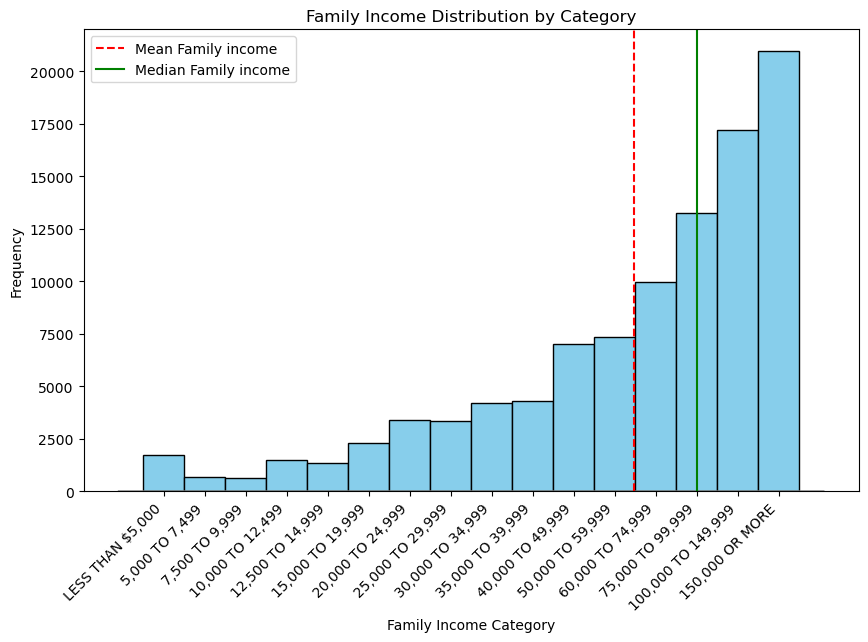

In [13]:
# Create a histogram for income distribution using generated labels
plt.figure(figsize=(10, 6))  # Sets the figure size for better readability
plt.hist(df_income['family_income'], bins=range(1, 18), align='left', color='skyblue', edgecolor='black')
# KDE plot overlay
sns.kdeplot(df_income['family_income'], color='grey', bw_adjust=1)  

plt.title('Family Income Distribution by Category')
plt.xlabel('Family Income Category')
plt.ylabel('Frequency')
plt.axvline(df_income['family_income'].mean(), color='r', linestyle='--',label='Mean Family income')

plt.axvline(df_income['family_income'].median(), color='g', linestyle='-',label='Median Family income')

plt.xticks(range(1, 17), category_labels, rotation=45, ha='right')  # Set custom labels and rotate them for better visibility

plt.legend()

plt.show()

## Hourly earnings distribution analysis                

In [14]:
weekly_earn_df = data_filtered[data_filtered['weekly_earnings'] != -1]

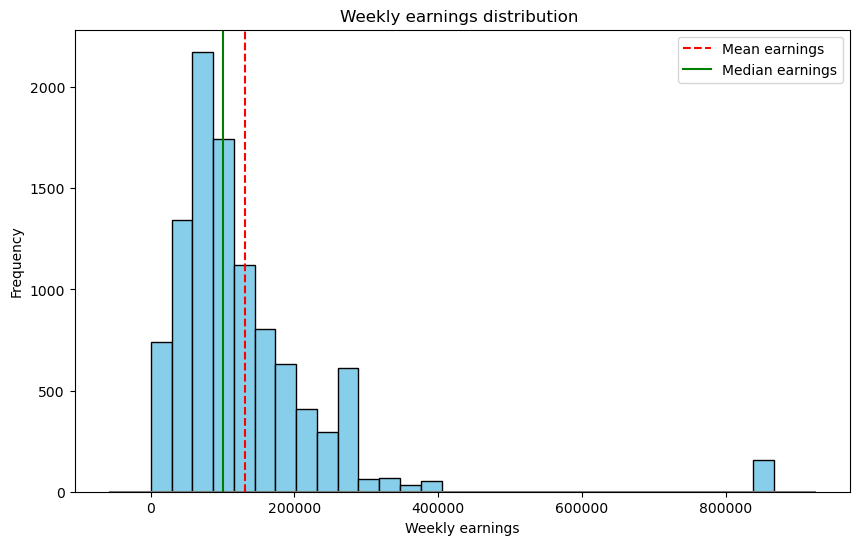

In [15]:
plt.figure(figsize=(10, 6))  # Sets the figure size
plt.hist(weekly_earn_df['weekly_earnings'], bins=30, color='skyblue', edgecolor='black')  # Plots the histogram
sns.kdeplot(weekly_earn_df['weekly_earnings'], color='grey', bw_adjust=1)  
plt.title('Weekly earnings distribution ')  # Adds a title to the histogram
plt.xlabel('Weekly earnings')  # Adds a label to the x-axis
plt.ylabel('Frequency')  # Adds a label to the y-axis
plt.axvline(weekly_earn_df['weekly_earnings'].mean(), color='r', linestyle='--',label='Mean earnings')

plt.axvline(weekly_earn_df['weekly_earnings'].median(), color='g', linestyle='-',label='Median earnings')
plt.legend()

plt.show()  # Displays the histogram

### Imputing Missing Values

In [16]:
# Create a copy of data_filtered to a new DataFrame
imputed_df = data_filtered.copy()

# Ensure that -1 is a valid category for categorical columns and replace NaN values in the copy
for column in imputed_df.columns:
    if imputed_df[column].dtype.name == 'category':
        if -1 not in imputed_df[column].cat.categories:
            imputed_df[column] = imputed_df[column].cat.add_categories([-1])
    imputed_df[column].fillna(-1, inplace=True)

In [17]:
# Generate the theoretical normal distribution based on the observed data
data_norm = norm.rvs(size=len(imputed_df['weekly_earnings']))

# Perform the Kolmogorov-Smirnov test
ks_test = kstest(imputed_df['weekly_earnings'], 'norm', args=(data_norm.mean(), data_norm.std()))
print(f"KS Test Statistic: {ks_test.statistic}, P-value: {ks_test.pvalue}")

KS Test Statistic: 0.7595569241473179, P-value: 0.0


The distribution of the data (weekly_earnings) deviates significantly from a normal distribution.

What This Means:
High KS Statistic: The closeness of the test statistic to 1.0 indicates a significant divergence between the empirical distribution theour data and the theoretical normal distribution.
P-value of 0.0: This effectively rejects the null hypothesis that the data are drawn from a normal distribution.

## Spearman Test

For analyzing the relationship between two ordinal variables or two continuous variables that do not meet the assumptions of normality required for Pearson's correlation coefficient, Spearman's correlation is ideal. It assesses how well the relationship between the variables can be described using a monotonic function.

In [18]:
# Calculate Spearman correlation for each column against 'family_income'
spearman_results = []
for column in imputed_df.columns:
    if column != 'family_income':  # Avoid comparing the column with itself
        correlation, p_value = spearmanr(imputed_df['family_income'], imputed_df[column])
        spearman_results.append((column, correlation, p_value))

# Create a DataFrame to display the results more neatly
spearman_results_df = pd.DataFrame(spearman_results, columns=['Variable', 'Spearman Correlation', 'P-value'])
spearman_results_df.sort_values(by='Spearman Correlation', ascending=False)

,Variable,Spearman Correlation,P-value
25,health_status_impacting_work,0.655699,0.000000e+00
21,citizenship_status,0.600516,0.000000e+00
18,race,0.577316,0.000000e+00
4,education_level,0.545549,0.000000e+00
2,household_members,0.544475,0.000000e+00
20,gender,0.534893,0.000000e+00
19,age,0.457240,0.000000e+00
9,primary_industry_code_job1,0.425730,0.000000e+00
10,industry_code_job1,0.424667,0.000000e+00
5,professional_certification1,0.416409,0.000000e+00


# Visualization

## Employment Status Distribution

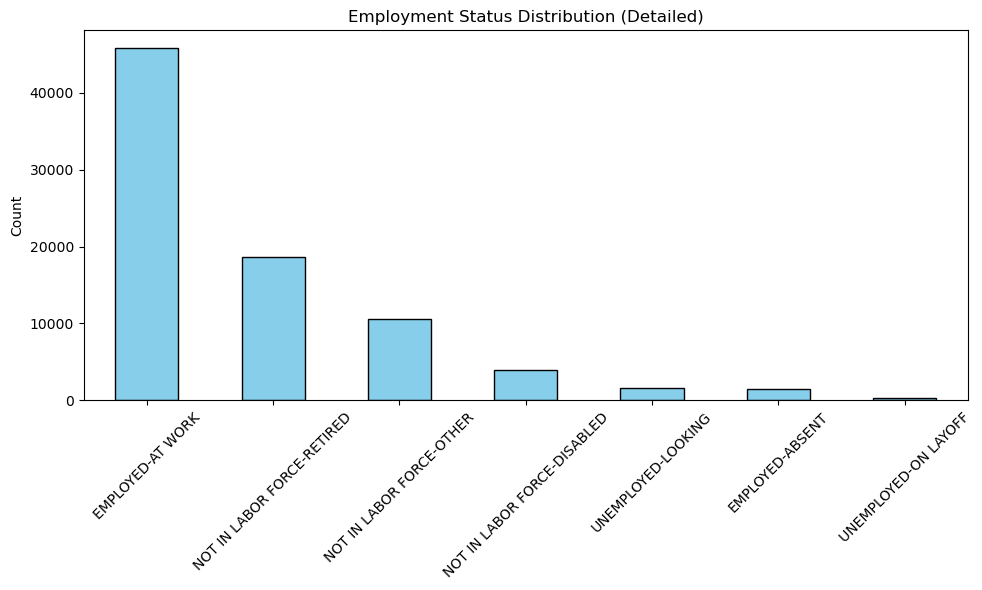

In [19]:
# Given employment labels for direct mapping from the codes to their descriptions
employment_labels = [
    'EMPLOYED-AT WORK',
    'EMPLOYED-ABSENT',
    'UNEMPLOYED-ON LAYOFF',
    'UNEMPLOYED-LOOKING',
    'NOT IN LABOR FORCE-RETIRED',
    'NOT IN LABOR FORCE-DISABLED',
    'NOT IN LABOR FORCE-OTHER'
]

# Mapping from employment status codes to their descriptions
employment_status_descriptions = {i+1: label for i, label in enumerate(employment_labels)}

# Applying the mapping to the 'employment_status' column
data_filtered['Employment_Status_Description'] = data_filtered['employment_status'].map(employment_status_descriptions)

# Counting occurrences for each employment status description
employment_status_description_counts = data_filtered['Employment_Status_Description'].value_counts()

# Creating a bar plot for employment status descriptions before aggregation
plt.figure(figsize=(10, 6))
employment_status_description_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Employment Status Distribution (Detailed)')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('EMPstatusD.png')
plt.show()



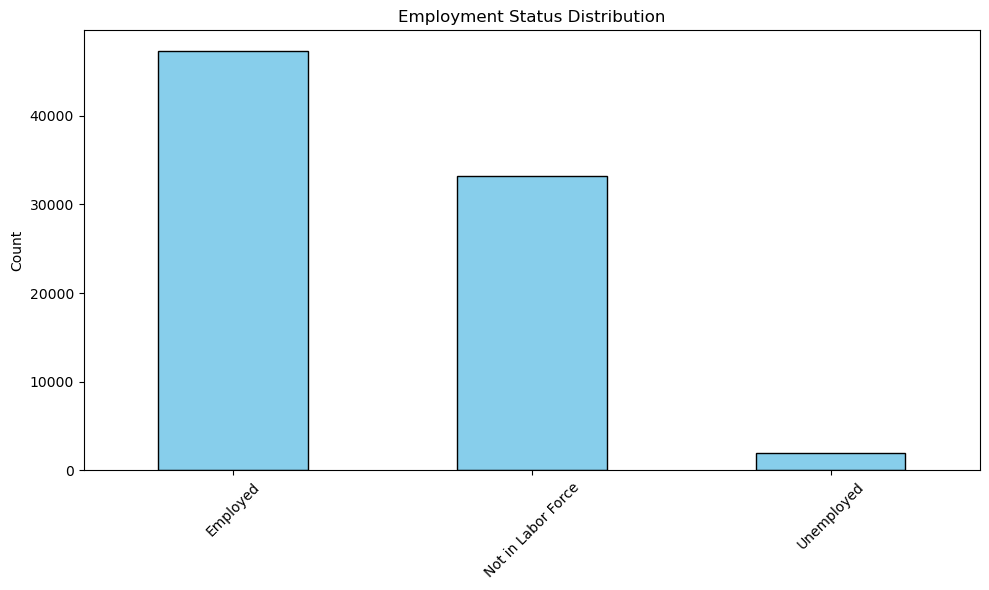

In [20]:
# Grouping data based on the 'employment_status' column and aggregating counts for each status
employment_status_counts = data_filtered['employment_status'].value_counts().sort_index()

# Mapping codes to human-readable categories based on the provided information
employment_status_mapping = {
    1: 'Employed',
    2: 'Employed',
    3: 'Unemployed',
    4: 'Unemployed',
    5: 'Not in Labor Force',
    6: 'Not in Labor Force',
    7: 'Not in Labor Force'
}

# Applying the mapping to aggregate counts under "Employed", "Unemployed", and "Not in Labor Force" categories
employment_status_aggregated = employment_status_counts.rename(index=employment_status_mapping).groupby(level=0).sum()

# Visualization

# Creating a bar plot
plt.figure(figsize=(10, 6))
employment_status_aggregated.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Employment Status Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)


# Showing the plot
plt.tight_layout()
plt.savefig('EMPstatusDagg.png')
plt.show()


## Education Level Distribution

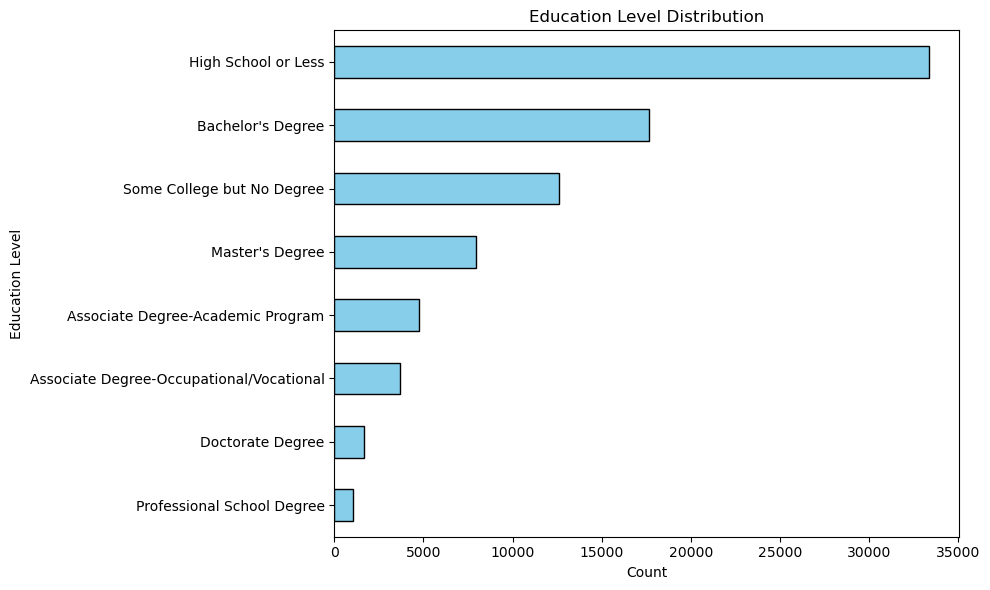

In [21]:
# Mapping the education levels to more generalized groups for clarity and aggregation
education_mapping = {
    31: 'High School or Less',
    32: 'High School or Less',
    33: 'High School or Less',
    34: 'High School or Less',
    35: 'High School or Less',
    36: 'High School or Less',
    37: 'High School or Less',
    38: 'High School or Less',
    39: 'High School or Less',
    40: 'Some College but No Degree',
    41: 'Associate Degree-Occupational/Vocational',
    42: 'Associate Degree-Academic Program',
    43: "Bachelor's Degree",
    44: "Master's Degree",
    45: 'Professional School Degree',
    46: 'Doctorate Degree'
}

# Applying the mapping to the 'education_level' column to create a new column for the aggregated groups
data_filtered['Education_Level_Grouped'] = data_filtered['education_level'].map(education_mapping)

# Counting the number of occurrences in each education level group
education_level_counts = data_filtered['Education_Level_Grouped'].value_counts().sort_values()

# Creating a bar plot for the aggregated education levels
plt.figure(figsize=(10, 6))
education_level_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Education Level Distribution')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.tight_layout()
plt.savefig('ELD.png')
plt.show()


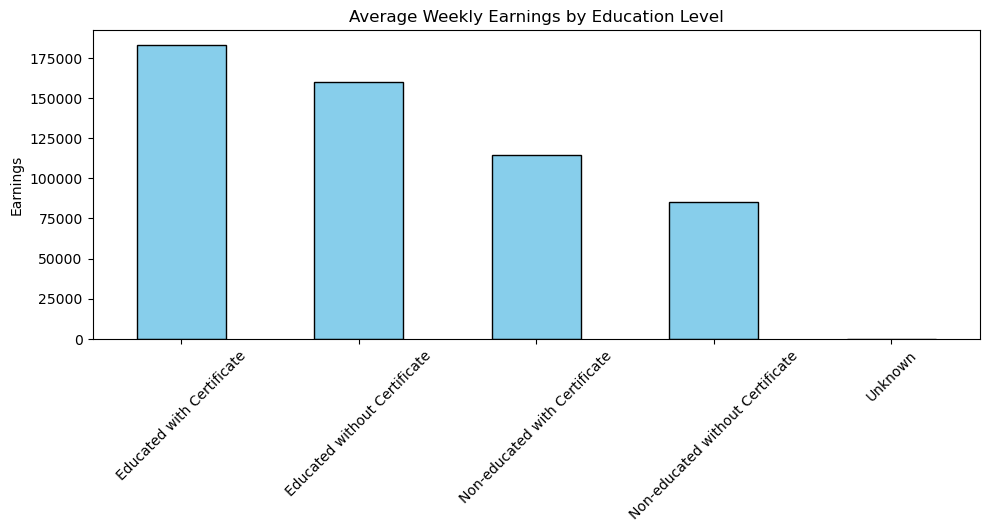

In [22]:
# Visualization 4: Distribution of income by Education Level
education_threshold = 41  # Threshold for considering someone as educated
certificate_col = 'professional_certification1'  

# Ensure 'education_level' and 'professional_certification1' are in a suitable format
data_filtered['education_level_numeric'] = pd.to_numeric(data_filtered['education_level'], errors='coerce')

# Define the four groups
conditions = [
    (data_filtered['education_level_numeric'] < education_threshold) & (data_filtered[certificate_col] == 1),
    (data_filtered['education_level_numeric'] < education_threshold) & (data_filtered[certificate_col] != 1),
    (data_filtered['education_level_numeric'] >= education_threshold) & (data_filtered[certificate_col] == 1),
    (data_filtered['education_level_numeric'] >= education_threshold) & (data_filtered[certificate_col] != 1)
]

choices = [
    'Non-educated with Certificate',
    'Non-educated without Certificate',
    'Educated with Certificate',
    'Educated without Certificate'
]

data_filtered['Education_Certificate_Group'] = np.select(conditions, choices, default='Unknown')

# Calculate average weekly earnings for each group
grouped_earnings = data_filtered.groupby('Education_Certificate_Group')['weekly_earnings'].mean()
grouped_earnings = grouped_earnings.drop(columns=['Unknown'])

# Plotting
plt.figure(figsize=(10, 6))
grouped_earnings.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Weekly Earnings by Education Level')
plt.ylabel('Earnings')
plt.xlabel('')
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('AVEbyEducation.png')
plt.show()




## Employment Status Distribution by Education and Certification Status

<Figure size 1000x600 with 0 Axes>

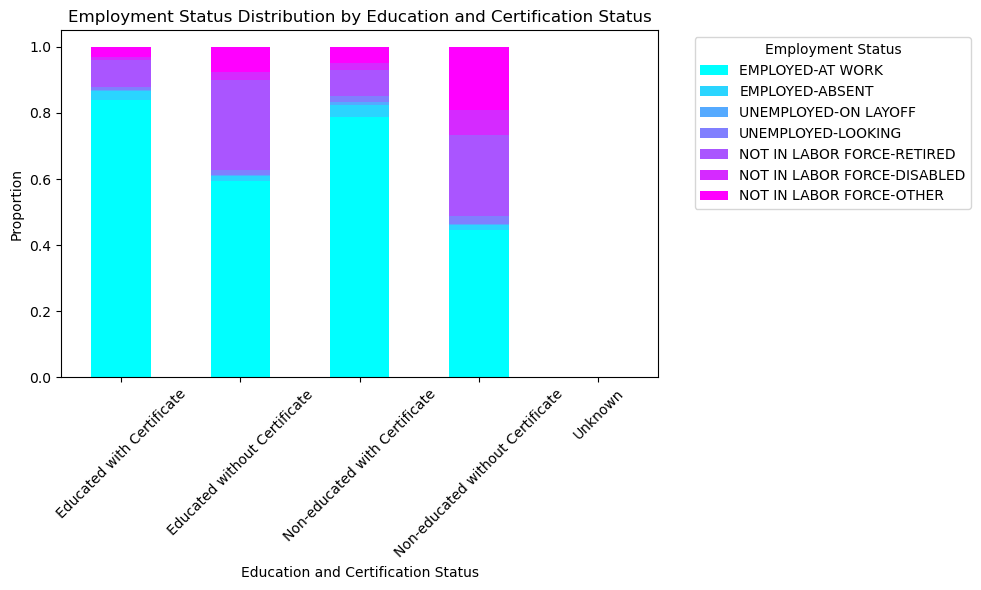

In [23]:
# Creating a new dataframe with just the necessary columns
df_employment_education = data_filtered[['Education_Certificate_Group', 'Employment_Status_Description']]

# Getting counts of each employment status within each education group
employment_distribution = df_employment_education.groupby(['Education_Certificate_Group', 'Employment_Status_Description']).size().unstack(fill_value=0)

# Normalizing the counts to get proportions
employment_proportions = employment_distribution.div(employment_distribution.sum(axis=1), axis=0)

# Plotting the proportions as a stacked bar chart
plt.figure(figsize=(10, 6))
employment_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='cool')
plt.title('Employment Status Distribution by Education and Certification Status')
plt.xlabel('Education and Certification Status')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('AVEbyEducationANDcer.png')
plt.show()

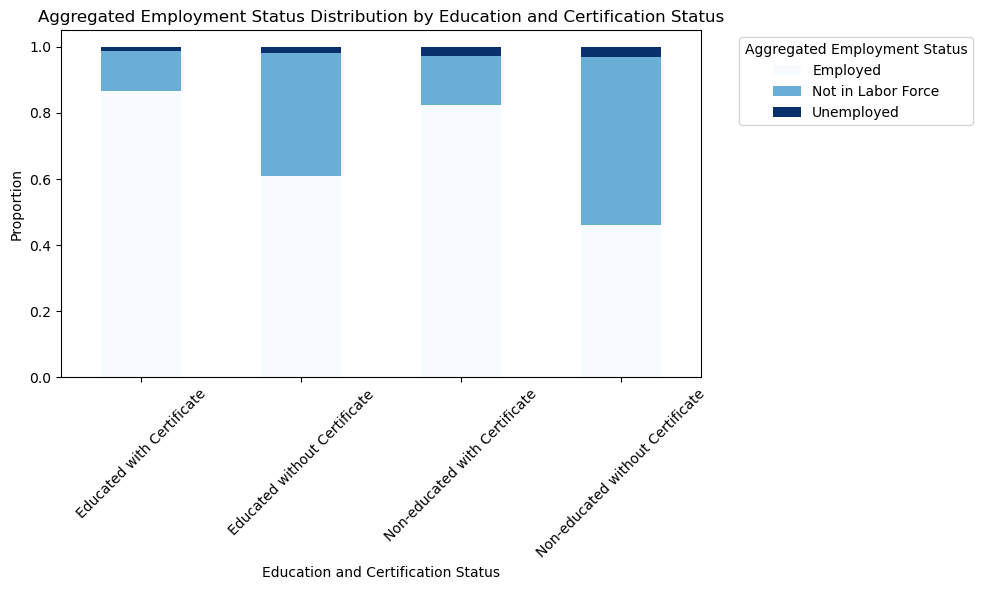

In [24]:
# For this approach, we simulate the aggregation based on the 'Employment_Status_Description' column
# and the education/certification groups we've already defined in 'Education_Certificate_Group'

# Mapping from detailed to aggregated employment statuses
employment_status_to_aggregated = {
    'EMPLOYED-AT WORK': 'Employed',
    'EMPLOYED-ABSENT': 'Employed',
    'UNEMPLOYED-ON LAYOFF': 'Unemployed',
    'UNEMPLOYED-LOOKING': 'Unemployed',
    'NOT IN LABOR FORCE-RETIRED': 'Not in Labor Force',
    'NOT IN LABOR FORCE-DISABLED': 'Not in Labor Force',
    'NOT IN LABOR FORCE-OTHER': 'Not in Labor Force'
}

# Applying the mapping to aggregate employment status descriptions
data_filtered['Aggregated_Employment_Status'] = data_filtered['Employment_Status_Description'].map(employment_status_to_aggregated)

# Calculating the distribution of aggregated employment statuses within each education group
agg_employment_distribution = data_filtered.groupby(['Education_Certificate_Group', 'Aggregated_Employment_Status']).size().unstack(fill_value=0)

# Normalizing the counts to get proportions
agg_employment_proportions = agg_employment_distribution.div(agg_employment_distribution.sum(axis=1), axis=0)

# Plotting the proportions as a stacked bar chart for aggregated employment status
agg_employment_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Blues')
plt.title('Aggregated Employment Status Distribution by Education and Certification Status')
plt.xlabel('Education and Certification Status')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Aggregated Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('ProportionbyEducation.png')
plt.show()


## Distribution of Professional Certification Among Employed Individuals

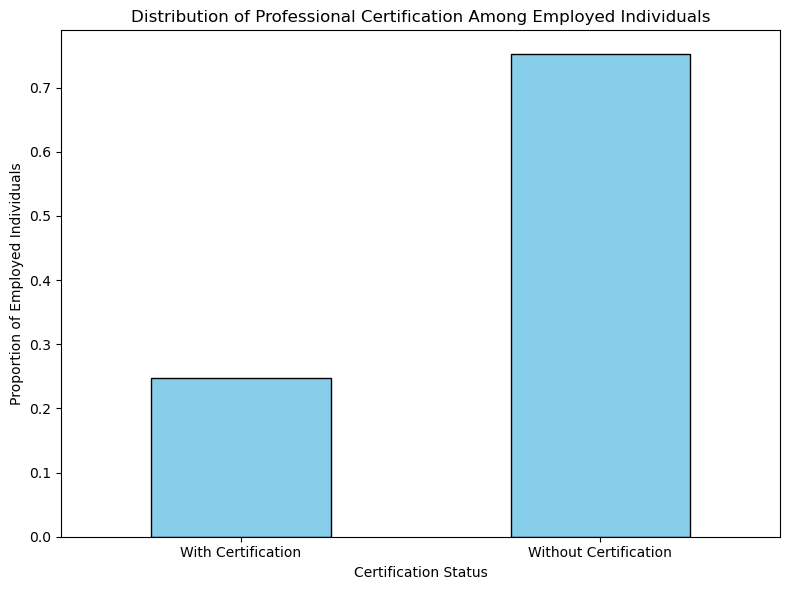

In [25]:
# Filtering the dataframe for employed individuals based on 'employment_status' == 1.0
employed_data = data_filtered[data_filtered['employment_status'] == 1.0]

# Distribution of professional certification among employed individuals
# Assuming 'professional_certification1' == 1.0 indicates holding a professional certification
certification_counts = employed_data['professional_certification1'].value_counts(normalize=True).sort_index()

# Mapping certification status for clarity
certification_mapping = {1.0: 'With Certification', 2.0: 'Without Certification'}
certification_counts.index = certification_counts.index.map(certification_mapping)

# Plotting
plt.figure(figsize=(10, 6))
certification_counts.plot(kind='bar', figsize=(8, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Professional Certification Among Employed Individuals')
plt.xlabel('Certification Status')
plt.ylabel('Proportion of Employed Individuals')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('ProfCertificationDISTR.png')
plt.show()


C:\Users\almas\AppData\Local\Temp\ipykernel_16916\3020723142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data['Certification_Status'] = earnings_data['professional_certification1'].map({1: 'With Certification', 2: 'Without Certification'})


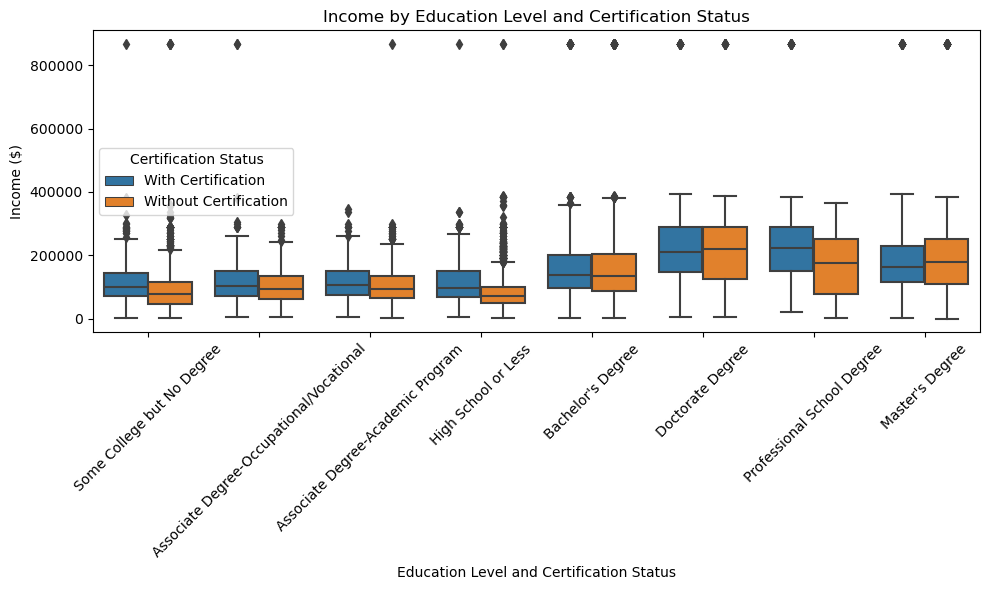

In [26]:
#Preparing the data: Filtering out negative earnings as they may represent missing or placeholder values
earnings_data = data_filtered[data_filtered['weekly_earnings'] > 0]

# Mapping certification status for readability
earnings_data['Certification_Status'] = earnings_data['professional_certification1'].map({1: 'With Certification', 2: 'Without Certification'})

# Creating the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=earnings_data, x='Education_Level_Grouped', y='weekly_earnings', hue='Certification_Status')
plt.title('Income by Education Level and Certification Status')
plt.xticks(rotation=45)
plt.ylabel('Income ($)')
plt.xlabel('Education Level and Certification Status')
plt.legend(title='Certification Status')
plt.tight_layout()
plt.savefig('earningByEducationAndCert.png')
# Show the plot
plt.show()

In [27]:
if -1 not in data_filtered['primary_industry_code_job1'].cat.categories:
    data_filtered['primary_industry_code_job1'] = data_filtered['primary_industry_code_job1'].cat.add_categories([-1])

data_filtered['primary_industry_code_job1'] = data_filtered['primary_industry_code_job1'].fillna(-1)

In [28]:
# Mapping industries from the provided list to more readable names
industry_mapping = {
    1: 'Agriculture, Forestry, Fishing, and Hunting',
    2: 'Mining',
    3: 'Construction',
    4: 'Manufacturing - Durable Goods',
    5: 'Manufacturing - Non-Durable Goods',
    6: 'Wholesale Trade',
    7: 'Retail Trade',
    8: 'Transportation and Warehousing',
    9: 'Utilities',
    10: 'Information',
    11: 'Finance and Insurance',
    12: 'Real Estate and Rental and Leasing',
    13: 'Professional Scientific and Technical Services',
    14: 'Management, Administrative and Waste Management Services',
    15: 'Educational Services',
    16: 'Health Care and Social Assistance',
    17: 'Arts, Entertainment, and Recreation',
    18: 'Accommodation and Food Services',
    19: 'Private Households',
    20: 'Other Services, Except Private Households',
    21: 'Public Administration',
    22: 'Armed Forces',
    -1: 'Unspecified/Missing Data',
    np.nan: 'Unspecified/Missing Data'  # This will handle NaN values during the mapping process
}

# Mapping certification status for readability
data_filtered['Certification_Status'] = data_filtered['professional_certification1'].map({1: 'With Certification', 2: 'Without Certification'})

# Applying the industry mapping
data_filtered['Industry'] = data_filtered['primary_industry_code_job1'].map(industry_mapping)

# Calculating the count of certified vs. non-certified individuals within each industry
certification_industry_distribution = pd.crosstab(data_filtered['Industry'], data_filtered['Certification_Status'], normalize='index')

'''
# Plotting the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(certification_industry_distribution, annot=True, linewidths=.5, cmap='coolwarm', fmt=".2f")
plt.title('Concentration of Certifications Across Industries')
plt.ylabel('Industry')
plt.xlabel('Certification Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('heatmap_high_dpi.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
'''


'\n# Plotting the heatmap\nplt.figure(figsize=(15, 15))\nsns.heatmap(certification_industry_distribution, annot=True, linewidths=.5, cmap=\'coolwarm\', fmt=".2f")\nplt.title(\'Concentration of Certifications Across Industries\')\nplt.ylabel(\'Industry\')\nplt.xlabel(\'Certification Status\')\nplt.xticks(rotation=45, ha=\'right\')\nplt.tight_layout()\nplt.savefig(\'heatmap_high_dpi.png\', dpi=300, bbox_inches=\'tight\')\n\n# Show the plot\nplt.show()\n'

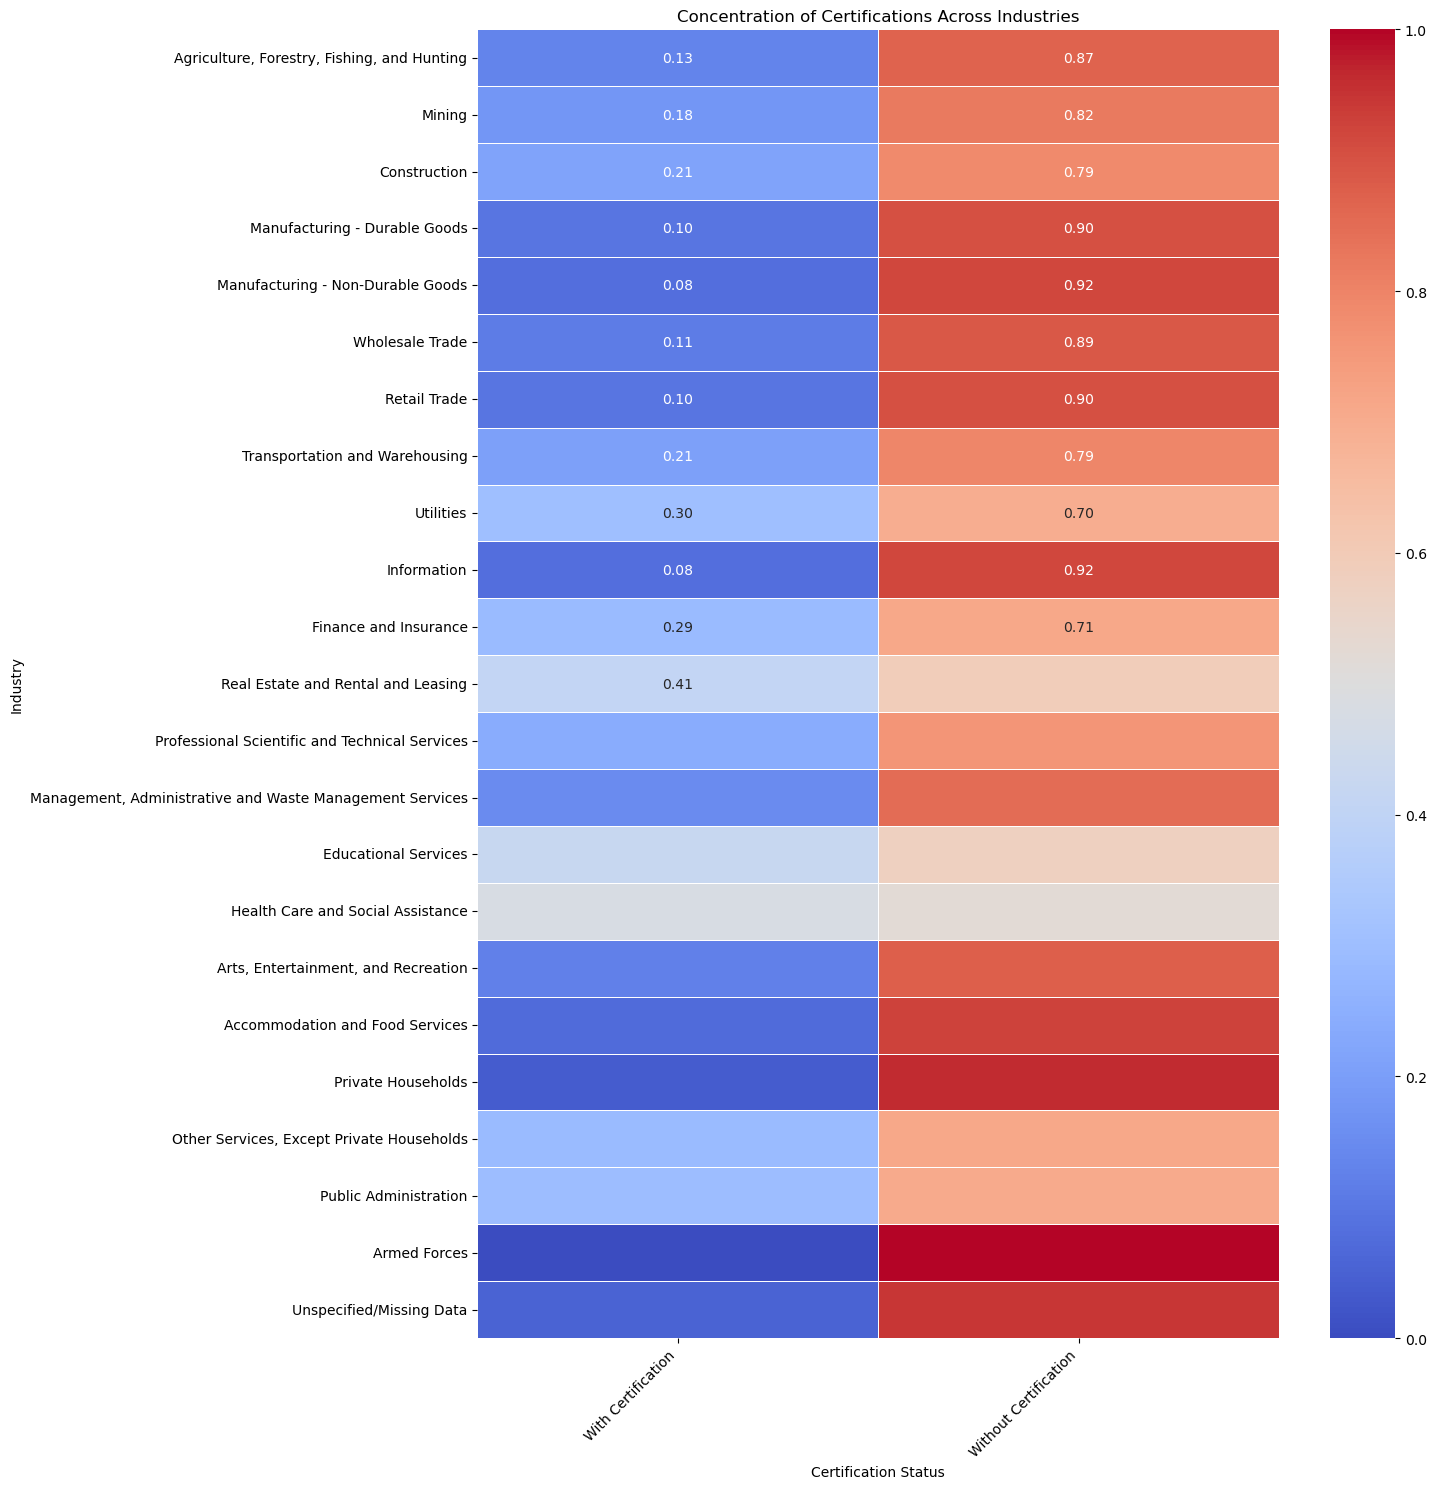

In [30]:
# Plotting the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(certification_industry_distribution, annot=True, linewidths=.5, cmap='coolwarm', fmt=".2f")
plt.title('Concentration of Certifications Across Industries')
plt.ylabel('Industry')
plt.xlabel('Certification Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [29]:
certification_industry_distribution

Certification_Status,With Certification,Without Certification
Industry,,
"Agriculture, Forestry, Fishing, and Hunting",0.130290,0.869710
Mining,0.177606,0.822394
Construction,0.212188,0.787812
Manufacturing - Durable Goods,0.096842,0.903158
Manufacturing - Non-Durable Goods,0.080851,0.919149
Wholesale Trade,0.111111,0.888889
Retail Trade,0.095652,0.904348
Transportation and Warehousing,0.205235,0.794765
Utilities,0.302734,0.697266


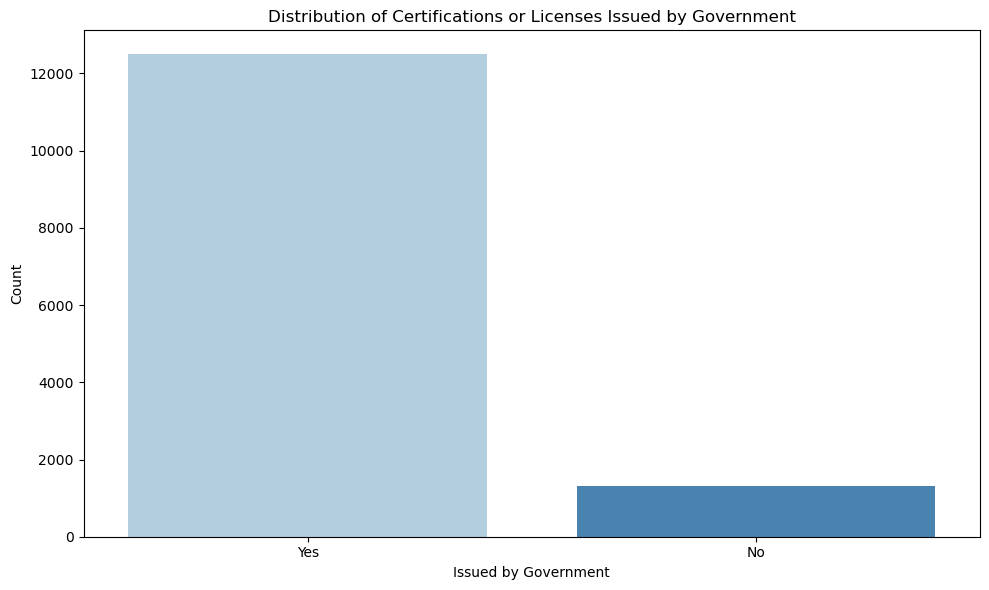

In [30]:
# Mapping WERE ANY OF CERTIFICATIONS OR LICENSES ISSUED BY THFEDERAL, STATE, OR LOCAL
															
# Mapping
license_mapping = {1: 'Yes', 2: 'No'}
data_filtered['Is_state_license'] = data_filtered['cert_issued_by_state_or_gov'].map(license_mapping)

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(data=data_filtered, x='Is_state_license', palette='Blues')
plt.title('Distribution of Certifications or Licenses Issued by Government')
plt.xlabel('Issued by Government')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('DistLICorGov.png')
plt.show()

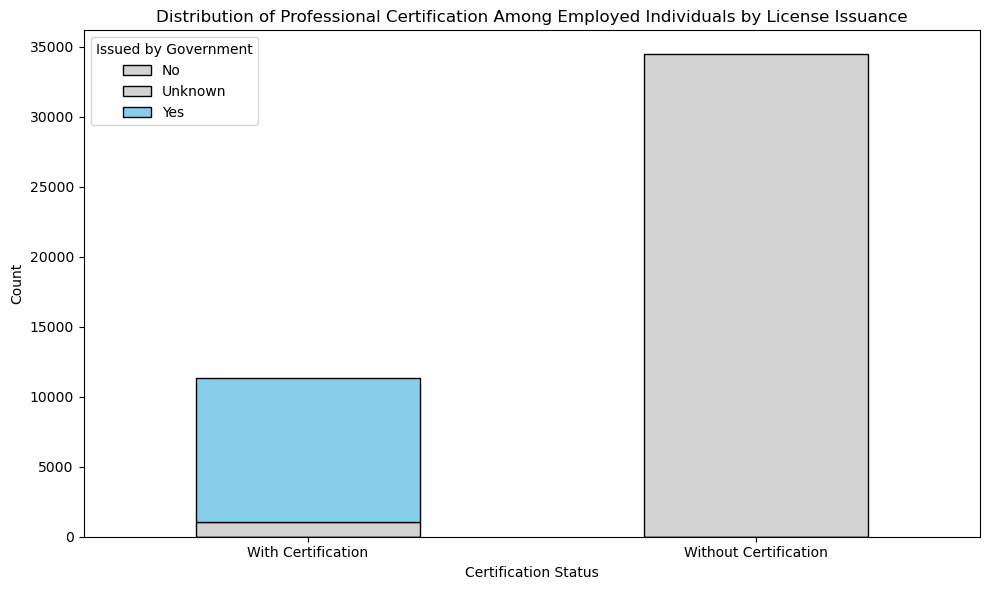

In [31]:
# Mapping license status
license_mapping = {1: 'Yes', 2: 'No'}
data_filtered['Is_state_license'] = data_filtered['cert_issued_by_state_or_gov'].map(license_mapping)

# Handle NaN values in 'Is_state_license' by filling with 'Unknown'
data_filtered['Is_state_license'].fillna('Unknown', inplace=True)

# Filtering for employed individuals
employed_data = data_filtered[data_filtered['employment_status'] == 1.0].copy()

# Mapping certification status
certification_mapping = {1.0: 'With Certification', 2.0: 'Without Certification'}
employed_data.loc[:, 'Certification_Status'] = employed_data['professional_certification1'].map(certification_mapping)

# Creating the pivot table
pivot_table = employed_data.pivot_table(index='Certification_Status', columns='Is_state_license', aggfunc='size', fill_value=0, observed=True)

# Plotting
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightgray', 'lightgray', 'skyblue', ], edgecolor='black')
plt.title('Distribution of Professional Certification Among Employed Individuals by License Issuance')
plt.xlabel('Certification Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Issued by Government')
plt.tight_layout()
plt.show()


## Demographic

In [32]:
# Filter the dataset for relevant columns and remove rows with negative or zero earnings
filtered_data = data_filtered[['weekly_earnings', 'race', 'gender', 'citizenship_status']]
filtered_data = filtered_data[filtered_data['weekly_earnings'] > 0]

# Mapping for race, gender, and citizenship status to improve readability
race_mapping = {
                	1:  	'White Only',					
					2:  	'Black Only',					 
					3:  	'American Indian, Alaskan',		   
					4:  	'Asian Only',					 
					5:  	'Hawaiian',		      
					6:  	'Mixed', 					      
					7: 	    'Mixed',					   
					8:  	'Mixed',					      
					9:  	'Mixed',					      
					10: 	'Mixed',					      
					11:  	'Mixed',					      
					12:  	'Mixed',					        	
					13:  	'Mixed',						        
					14:  	'Mixed',
					15: 	'Mixed',						      
					16: 	'Mixed',
					17:  	'Mixed',
					18:	    'Mixed',						        					
					19:	    'Mixed',						        
					20:  	'Mixed',
					21:	    'Mixed',
					22:	    'Mixed',				        
					23:  	'Mixed',
					24:	    'Mixed',						        
					25:	    'Mixed',					        
					26 : 	'Mixed'
}
gender_mapping = {
    1: "Male",
    2: "Female"
}
citizenship_mapping = {
    1:	'NATIVE',
    2:	'PR OR OTHER ISLAND', 
    3:	'NATIVE, BORN ABROAD',
    4:	'NATURALIZATION',
    5:	'NOT A CITIZEN'
}

In [33]:
# Apply mapping
filtered_data['race'] = filtered_data['race'].map(race_mapping)
filtered_data['gender'] = filtered_data['gender'].map(gender_mapping)
filtered_data['citizenship_status'] = filtered_data['citizenship_status'].map(citizenship_mapping)


In [34]:
# Calculate mean weekly earnings for each category
mean_earnings_by_race = filtered_data.groupby('race')['weekly_earnings'].mean()
mean_earnings_by_gender = filtered_data.groupby('gender')['weekly_earnings'].mean()
mean_earnings_by_citizenship = filtered_data.groupby('citizenship_status')['weekly_earnings'].mean()

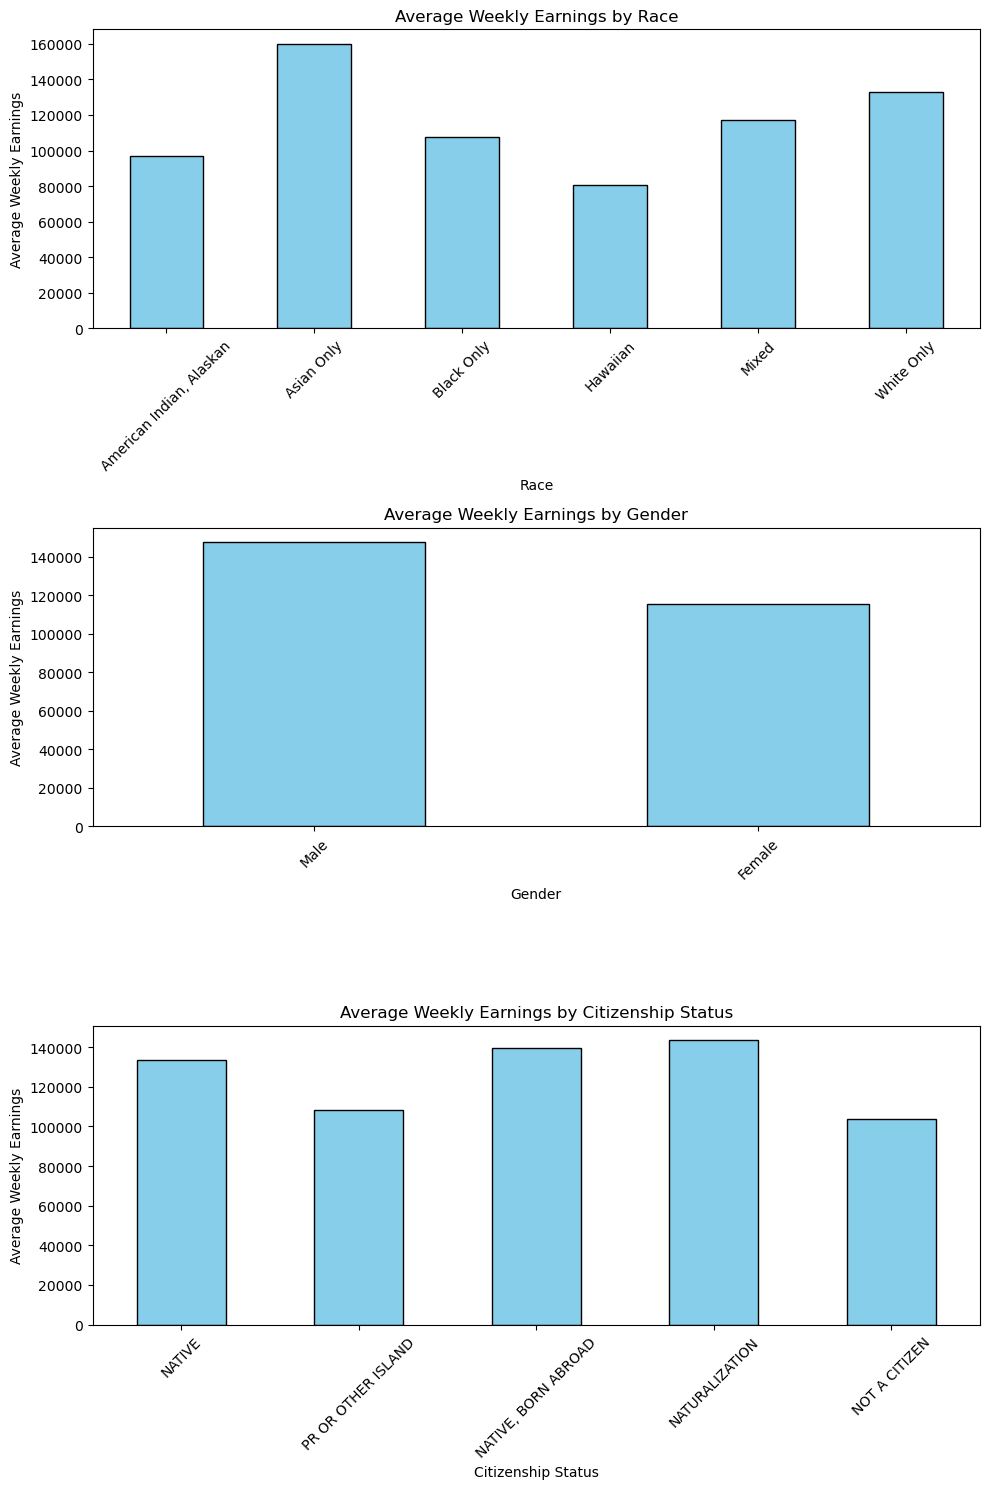

In [35]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Average Weekly Earnings by Race
mean_earnings_by_race.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Average Weekly Earnings by Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Average Weekly Earnings')
axes[0].tick_params(axis='x', rotation=45)

# Average Weekly Earnings by Gender
mean_earnings_by_gender.plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Average Weekly Earnings by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Average Weekly Earnings')
axes[1].tick_params(axis='x', rotation=45)

# Average Weekly Earnings by Citizenship Status
mean_earnings_by_citizenship.plot(kind='bar', ax=axes[2], color='skyblue', edgecolor='black')
axes[2].set_title('Average Weekly Earnings by Citizenship Status')
axes[2].set_xlabel('Citizenship Status')
axes[2].set_ylabel('Average Weekly Earnings')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('EarningByRace.png')
plt.show()

## AGE

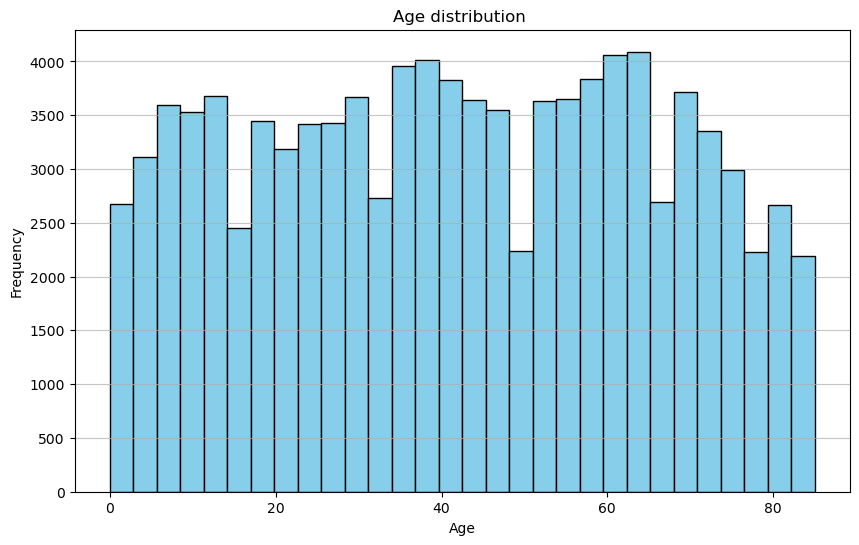

In [36]:
plt.figure(figsize=(10, 6))  # Sets the figure size
plt.hist(data_filtered['age'], bins=30, color='skyblue', edgecolor='black')  # Plots the histogram
plt.title('Age distribution ')  # Adds a title to the histogram
plt.xlabel('Age')  # Adds a label to the x-axis
plt.ylabel('Frequency')  # Adds a label to the y-axis
plt.grid(axis='y', alpha=0.75)  # Adds a grid, only horizontally, with some transparency
plt.savefig('Age.png')
plt.show()  # Displays the histogram

# Data Science Field

In [38]:
datascience_jobs = data_filtered[((data_filtered['occupation_code_job1'] == 1065) | (data_filtered['occupation_code_job1'] == 1240))]

In [39]:
agg_datascience_distribution = datascience_jobs.groupby(['Education_Certificate_Group', 'Aggregated_Employment_Status']).size().unstack(fill_value=0)

In [40]:
# Normalizing the counts to get proportions
agg_datascience_proportions = agg_datascience_distribution.div(agg_datascience_distribution.sum(axis=1), axis=0)

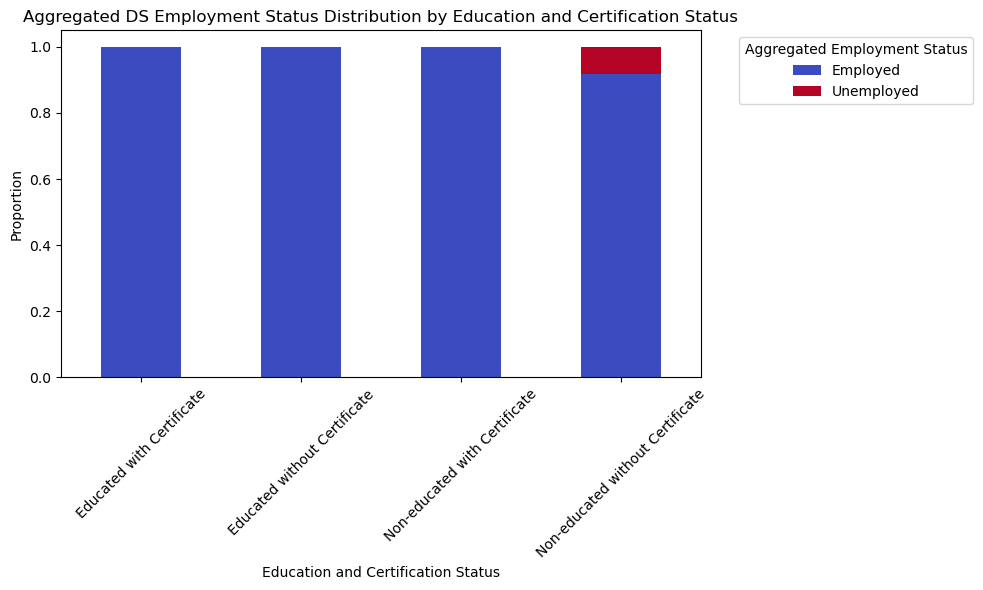

In [41]:
# Plotting the proportions as a stacked bar chart for aggregated employment status
agg_datascience_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Aggregated DS Employment Status Distribution by Education and Certification Status')
plt.xlabel('Education and Certification Status')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Aggregated Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('AggDSempStatus.png')
plt.show()

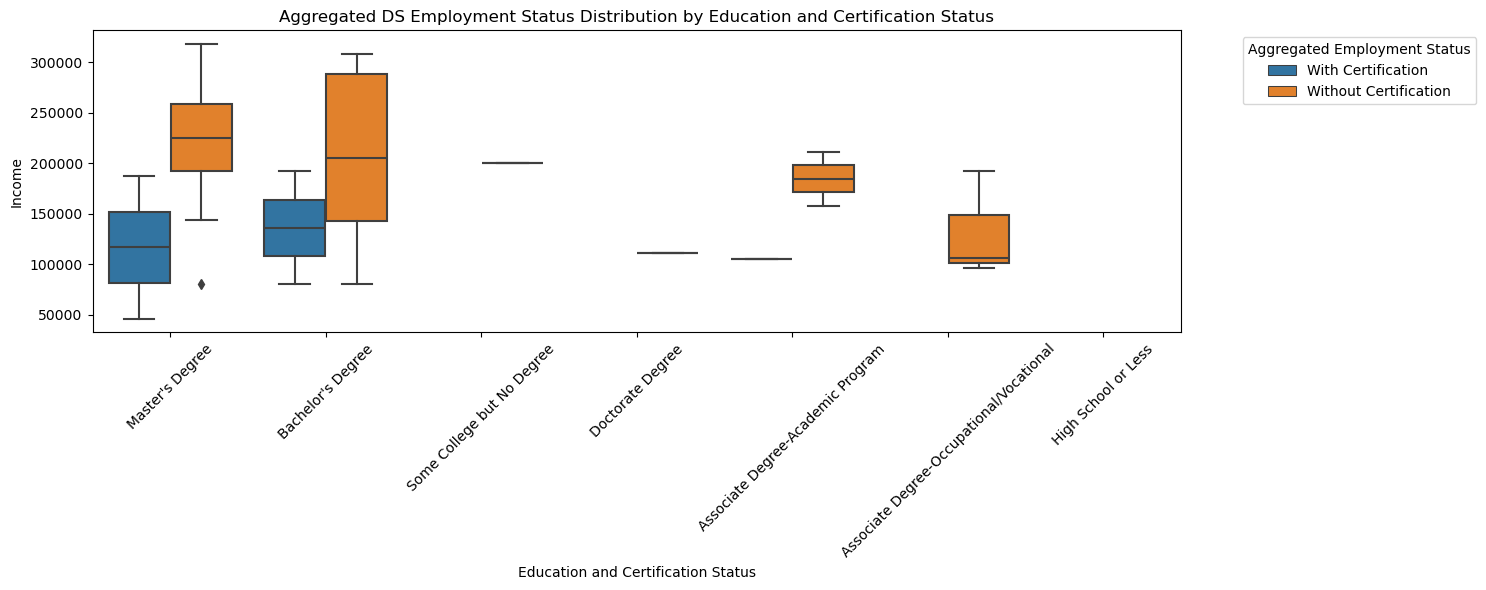

In [43]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=datascience_jobs, x='Education_Level_Grouped', y='weekly_earnings', hue='Certification_Status')
plt.title('Aggregated DS Employment Status Distribution by Education and Certification Status')
plt.xlabel('Education and Certification Status')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.legend(title='Aggregated Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('AggDSempStatusWithCertificate.png')
plt.show()

# Exploring Secondary Jobs

## Data Science Field

- 1065	Database administrators and architects		
	Combines:			
	15-1242	Database administrators		
	15-1243	Databas		
- 1240	Other mathematical science occupations		
	Combines:			
	 Mathematicians		
	 Statisticians		
	 Other mathematical science occupations		
	Combines:			
	 Data scientists		
	 Mathematical science occupations, all other	

In [44]:
# Filter the data
datascience_2jobs = data_filtered[((data_filtered['occupation_code_job1'] == 1065) | (data_filtered['occupation_code_job1'] == 1240)) &
                     (data_filtered['occupation_code_job2'].notna()) & (data_filtered['occupation_code_job2'] != -1)]

# Check the counts of each job code
datascience_2jobs['occupation_code_job1'].value_counts()


occupation_code_job1
1240.0    2
Name: count, dtype: int64

**Only two individual working in the Data Science industry have more than 1 job.**

## All Occupation

In [45]:
# Filter the data to include any valid second job
data_with_second_job = data_filtered[(data_filtered['occupation_code_job2'].notna()) & (data_filtered['occupation_code_job2'] != -1)]

# Check the counts of each primary job code
all_job_counts = data_with_second_job['occupation_code_job1'].value_counts()

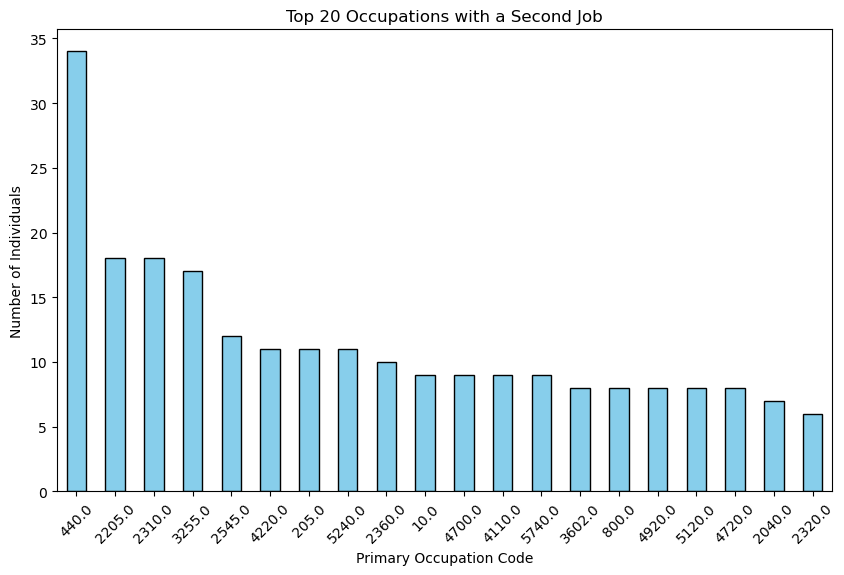

In [46]:
# Sort by descending order and select the top 20
top_10_jobs_with_second_job = all_job_counts.sort_values(ascending=False).head(20)

# Plot for top 10 job codes with a second job
plt.figure(figsize=(10, 6))
top_10_jobs_with_second_job.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 20 Occupations with a Second Job')
plt.xlabel('Primary Occupation Code')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=45)
plt.savefig('Top20OCC.png')
plt.show()


Dict:

- 440		Other managers		
	Combines:			 - Legislators		 - Funeral home managers   00 - Postmasters and mail superintendents26 - Personal service managers, all oth    440 - Managers, all 

- 2205	Postsecondary teachers	
- 2310	Elementary and middle school teachers
- 3255	Registered nurses
- 2545	Teaching assistants
- 4220	Janitors and building cleaners	
- 0205	Farmers, ranchers, and other agricultural managers
- 5240	Customer service representatives
- 2360	Other teachers and instructors		
	Combines: 			1	Adult basic education, adult secondary education, and English as a second language instructors		21	Self-enrichment teachers	031	Substitute teachers, short-term 3099	Teachers and instructors, all 
- 10      chief executives
- 4700	First-line supervisors of retail sales workers	
- 4110	Waiters and waitresses
- 5740	Secretaries and administrative assistants, except legal, medical, and executive	
- 3602	Personal care aides
- 0800	Accountants and auditors
- 4920	Real estate brokers and sales agents
- 5120	Bookkeeping, accounting, and auditing clerks	
- 4720	Cashiers
- 2040	Clergy
- 2320	econdary school teachersotherother	

In [47]:
employment_status_aggregated

employment_status
Employed              47268
Not in Labor Force    33166
Unemployed             1914
Name: count, dtype: int64

In [48]:
# Number of employed individuals
total_employed = 47268

# Number of individuals with a second job from the previously filtered data
individuals_with_second_job = len(data_with_second_job)

# Calculate the percentage
percentage_with_second_job = (individuals_with_second_job / total_employed) * 100
percentage_with_second_job


1.373021917576373

**There are only 1.37% of the population with a secondary job not taking into consideration the (out of labor force) in the calculation, otherwise it can drop down to around 0.8%**

## Factor Analysis

In [49]:
print(imputed_df.dtypes)

household_id                       int64
interview_outcome                  int64
household_members                  int64
family_income                      int64
highest_level_of_school          float64
education_level                  float64
professional_certification1     category
cert_issued_by_state_or_gov      float64
is_cert_required                 float64
employment_status               category
primary_industry_code_job1      category
industry_code_job1               float64
occupation_code_job1             float64
primary_industry_code_job2       float64
industry_code_job2               float64
occupation_code_job2             float64
earnings_first_job               float64
total_hours_worked                 int64
weekly_earnings                  float64
race                            category
age                              float64
gender                          category
citizenship_status              category
state_code                         int64
usual_hours_work

In [50]:
# Check the suitability for factor analysis
imputed_df = imputed_df.astype(int)

kmo_all, kmo_model = calculate_kmo(imputed_df)
chi_square_value, p_value = calculate_bartlett_sphericity(imputed_df)
print("KMO Test: ", kmo_model)
print("Bartlett’s Test: ", p_value)



KMO Test:  0.8164285539153504
Bartlett’s Test:  0.0


In [51]:
# Create factor analysis object and perform factor analysis using 3 factors
fa = FactorAnalyzer(n_factors=7, rotation='varimax')
fa.fit(imputed_df)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print(ev)

# Get the loadings
print(fa.loadings_)

# Get variance of each factors
print(fa.get_factor_variance())

[7.33993186 3.08057199 2.5386014  1.53034406 1.46422072 1.15775863
 1.0724717  1.00900758 1.00587145 0.99485191 0.97907228 0.89361334
 0.77710497 0.57988198 0.55864962 0.45553849 0.36454076 0.3027727
 0.27894664 0.18192945 0.17467718 0.09231255 0.08937351 0.04359748
 0.01685754 0.00978727 0.00771297]
[[ 1.32193660e-03  5.42390365e-04  1.37189213e-03 -3.29620104e-02
   9.77908051e-03 -1.74573982e-03  2.85019886e-02]
 [-2.72328412e-01 -5.87646612e-02 -1.09009000e-01 -2.35597182e-02
  -2.54286034e-02  1.35789848e-02 -1.81643499e-03]
 [ 6.66926350e-01  4.17194243e-02 -1.90530543e-01  1.63786469e-02
   2.27798914e-03  1.86428957e-01 -7.05435405e-05]
 [ 8.22234491e-01  2.61268045e-01  1.69286002e-01  2.29731587e-02
   1.15540698e-01  4.14438975e-03 -2.27846714e-02]
 [ 1.14011450e-01 -3.46134362e-03  5.48464324e-02  1.01105577e-02
  -1.26630211e-02  4.52777557e-01  1.40084773e-01]
 [ 4.37258973e-01  4.26415849e-01  7.55812039e-01  1.08116102e-02
   1.28507796e-01  1.32559993e-01  5.60916757e-

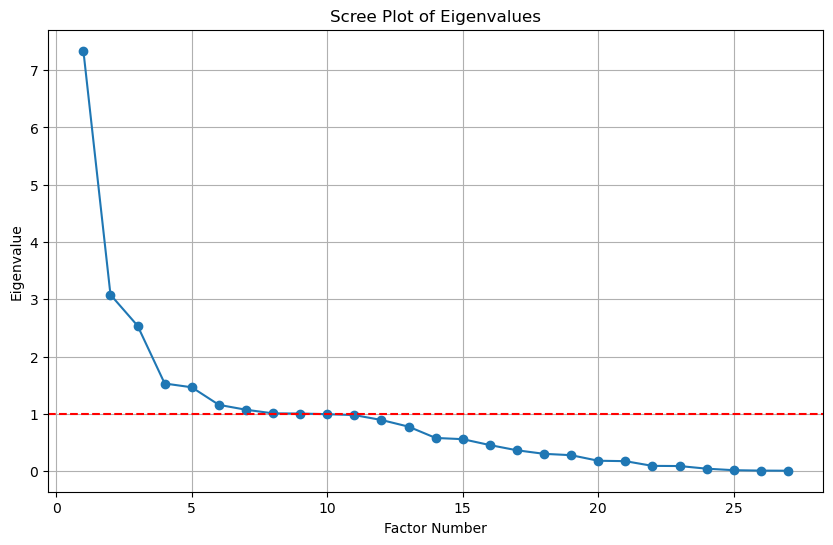

In [52]:
# Eigenvalues from  factor analysis output
eigenvalues = [7.33993186, 3.08057199, 2.5386014, 1.53034406, 1.46422072, 1.15775863,
               1.0724717, 1.00900758, 1.00587145, 0.99485191, 0.97907228, 0.89361334,
               0.77710497, 0.57988198, 0.55864962, 0.45553849, 0.36454076, 0.3027727,
               0.27894664, 0.18192945, 0.17467718, 0.09231255, 0.08937351, 0.04359748,
               0.01685754, 0.00978727, 0.00771297]

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.title('Scree Plot of Eigenvalues')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--')  # Kaiser criterion line (eigenvalue = 1)
plt.show()

# Modeling : 

## Converting Columns Type

In [59]:
# Convert columns to categorical, excluding any columns that are inherently numerical
categorical_columns = imputed_df.columns.drop(['weekly_earnings', 'total_hours_worked', 'usual_hours_worked']) 
imputed_df[categorical_columns] = imputed_df[categorical_columns].apply(lambda x: x.astype('category'))

Use Factor Analysis of Mixed Data (FAMD) if dataset includes both categorical and continuous variables.

## Handling Outlier 

In [60]:
# Remove rows where 'weekly_earnings' is -1
filtered_df = imputed_df[imputed_df['weekly_earnings'] != -1]

In [61]:
filtered_df.shape

(10246, 27)

In [62]:
imputed_df.shape

(126784, 27)

In [63]:
# Calculate IQR for 'weekly_earnings'
Q1 = filtered_df['weekly_earnings'].quantile(0.25)
Q3 = filtered_df['weekly_earnings'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
no_outliers_df = filtered_df[(filtered_df['weekly_earnings'] >= lower_bound) & (filtered_df['weekly_earnings'] <= upper_bound)]

# Display summary statistics of the data with and without outliers
outlier_summary = {
    "Original Data": filtered_df['weekly_earnings'].describe(),
    "Without Outliers": no_outliers_df['weekly_earnings'].describe()
}

outlier_summary

{'Original Data': count     10246.000000
 mean     131428.596721
 std      119913.265524
 min           0.000000
 25%       64600.000000
 50%      100000.000000
 75%      163461.000000
 max      867201.000000
 Name: weekly_earnings, dtype: float64,
 'Without Outliers': count      9936.000000
 mean     116449.199577
 std       73227.620519
 min           0.000000
 25%       64000.000000
 50%       98650.000000
 75%      154150.000000
 max      308000.000000
 Name: weekly_earnings, dtype: float64}

In [64]:
no_outliers_df

,household_id,interview_outcome,household_members,family_income,highest_level_of_school,education_level,professional_certification1,cert_issued_by_state_or_gov,is_cert_required,employment_status,...,total_hours_worked,weekly_earnings,race,age,gender,citizenship_status,state_code,usual_hours_worked,reason_for_unemployment,health_status_impacting_work
3,16011,201,1,13,-1,40,2,-1,-1,1,...,0,115400,1,50,2,1,1,40,-1,2
4,15011,201,2,16,-1,40,2,-1,-1,1,...,0,72000,1,58,1,1,1,40,-1,2
5,15011,201,2,16,-1,40,1,1,1,1,...,0,132450,1,48,2,1,1,60,-1,2
6,15011,201,2,15,-1,41,2,-1,-1,1,...,0,74000,1,47,2,1,1,40,-1,2
7,15011,201,2,15,-1,42,1,2,1,1,...,0,86520,1,58,1,1,1,40,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126533,16111,203,4,14,-1,39,2,-1,-1,1,...,0,104000,1,54,2,1,33,40,-1,2
126534,16111,203,4,14,-1,39,2,-1,-1,1,...,0,13000,1,21,1,1,33,10,-1,2
126609,15111,201,4,1,2,40,2,-1,-1,1,...,0,4260,1,24,2,1,41,6,-1,2
126760,16111,201,3,15,-1,43,2,-1,-1,1,...,0,141000,1,35,2,1,56,40,-1,2
